In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms,models
from torch.optim.lr_scheduler import *
import copy
import tqdm
import random
from PIL import Image
import torch.nn.functional as F

%matplotlib inline

BATCH_SIZE = 20
EPOCHS = 1
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
cPath = os.getcwd()
train_dir = cPath + '/data/train'
test_dir = cPath + '/data/test'
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

In [3]:
class CatDogDataset(Dataset):
    def __init__(self, file_list, dir, mode='train', transform = None):
        self.file_list = file_list
        self.dir = dir
        self.mode= mode
        self.transform = transform
        if self.mode == 'train':
            if 'dog' in self.file_list[0]:
                self.label = 1
            else:
                self.label = 0
            
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.dir, self.file_list[idx]))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            img = img.numpy()
            return img.astype('float32'), self.label
        else:
            img = img.numpy()
            return img.astype('float32'), self.file_list[idx]

In [4]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # 先调整图片大小至256x256
    transforms.RandomCrop((224, 224)),  # 再随机裁剪到224x224
    transforms.RandomHorizontalFlip(),  # 随机的图像水平翻转，通俗讲就是图像的左右对调
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # 归一化，数值是用ImageNet给出的数值
])


cat_files = [tf for tf in train_files if 'cat' in tf]
dog_files = [tf for tf in train_files if 'dog' in tf]

cats = CatDogDataset(cat_files, train_dir, transform = train_transform)
dogs = CatDogDataset(dog_files, train_dir, transform = train_transform)

train_set = ConcatDataset([cats, dogs])
train_loader = DataLoader(train_set, batch_size = BATCH_SIZE, shuffle=True, num_workers=0)

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

test_set = CatDogDataset(test_files, test_dir, mode='test', transform = test_transform)
test_loader = DataLoader(test_set, batch_size = BATCH_SIZE, shuffle=False, num_workers=0)

In [5]:
def refreshdataloader():    
    cat_files = [tf for tf in train_files if 'cat' in tf]
    dog_files = [tf for tf in train_files if 'dog' in tf]
    
    val_cat_files = []
    val_dog_files = []
    
    for i in range(0,1250):
        r = random.randint(0,len(cat_files)-1)
        val_cat_files.append(cat_files[r])
        val_dog_files.append(dog_files[r])
        cat_files.remove(cat_files[r])
        dog_files.remove(dog_files[r])
    
    cats = CatDogDataset(cat_files, train_dir, transform = train_transform)
    dogs = CatDogDataset(dog_files, train_dir, transform = train_transform)

    train_set = ConcatDataset([cats, dogs])
    train_loader = DataLoader(train_set, batch_size = BATCH_SIZE, shuffle=True, num_workers=1)
    
    val_cats = CatDogDataset(val_cat_files, train_dir, transform = test_transform)
    val_dogs = CatDogDataset(val_dog_files, train_dir, transform = test_transform)

    val_set = ConcatDataset([val_cats, val_dogs])
    val_loader = DataLoader(val_set, batch_size = BATCH_SIZE, shuffle=True, num_workers=1)
    
    return train_loader,val_loader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


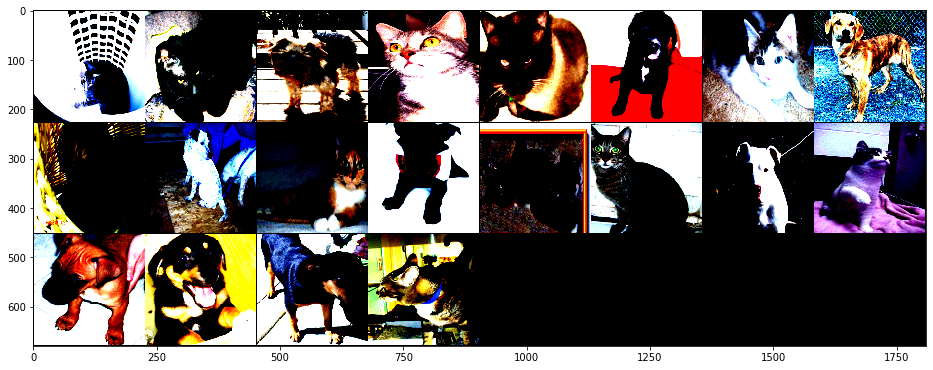

In [6]:
samples, labels = iter(train_loader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:BATCH_SIZE])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

In [8]:
class Net(nn.Module):
    def __init__(self, model):
        super(Net, self).__init__()
        # 取掉model的后1层
        self.resnet_layer = nn.Sequential(*list(model.children())[:-1])
        self.Linear_layer = nn.Linear(512, 2) #加上一层参数修改好的全连接层
 
    def forward(self, x):
        x = self.resnet_layer(x)
        x = x.view(x.size(0), -1)
        x = self.Linear_layer(x)
        return x

In [9]:
from torchvision.models.resnet import resnet18
resnet = resnet18(pretrained=True)
model = Net(resnet)
model = model.to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)  # 设置训练细节
scheduler = StepLR(optimizer, step_size=3)
criterion = nn.CrossEntropyLoss()

In [7]:
from torchvision.models.vgg import vgg16
model = vgg16(pretrained=True)
for parma in model.parameters():
    parma.requires_grad = False

model.classifier = nn.Sequential(nn.Linear(25088, 4096),
                                       nn.ReLU(),
                                       nn.Dropout(p=0.5),
                                       nn.Linear(4096, 4096),
                                       nn.ReLU(),
                                       nn.Dropout(p=0.5),
                                       nn.Linear(4096, 2))

for index, parma in enumerate(model.classifier.parameters()):
    if index == 6:
        parma.requires_grad = True
        
model = model.to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)  # 设置训练细节
scheduler = StepLR(optimizer, step_size=3)
criterion = nn.CrossEntropyLoss()

In [8]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    loss_list = []
    train_acc = 0.0
    percent = 5
    
    for batch_idx, (sample, target) in enumerate(train_loader):
        sample, target = sample.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(sample)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        loss = loss.item()
        
        pred = output.max(1, keepdim = True)[1] 
        train_acc += pred.eq(target.view_as(pred)).sum().item()
            
        if (batch_idx+1)%percent == 0:
            print('train epoch: {} [{}/{} ({:.0f}%)]\tloss: {:.6f}\t'.format(
                epoch, (batch_idx+1) * len(sample), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss))
            loss_list.append(loss)
                  
    train_acc = train_acc/len(train_loader.dataset)    
    print('\ntrain epoch: {}\taccuracy:{:.4f}% '.format(epoch,100.*train_acc))
    scheduler.step()
            
    return loss_list,train_acc

In [9]:
def val(model, device, val_loader,epoch):
    model.eval()
    val_loss =0
    correct = 0
    for sample, target in val_loader:
        with torch.no_grad():
            sample,target = sample.to(device),target.to(device)
            output = model(sample)
            
            val_loss += criterion(output, target).item()
            pred = output.max(1, keepdim = True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    val_loss *= BATCH_SIZE
    val_loss /= len(val_loader.dataset)
    val_acc= correct / len(val_loader.dataset)
    print("\nval set: epoch{} average loss: {:.4f}, accuracy: {}/{} ({:.4f}%) \n"
          .format(epoch, val_loss, correct, len(val_loader.dataset),100.* val_acc))
    return val_loss,100.*val_acc

In [10]:
def test(model, device, test_loader):
    model.eval()
    filename_list = []
    pred_list = []
    for sample, filename in test_loader:
        with torch.no_grad():
            sample = sample.to(device)
            output = model(sample)
            pred = torch.argmax(output, dim=1)
            
            filename_list += [n[:-4] for n in filename]
            pred_list += [p.item() for p in pred]
    
    submission = pd.DataFrame({"id":filename_list, "label":pred_list})
    submission.to_csv('preds_' + str(epoch) + '.csv', index=False) 

In [11]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [12]:
train_losses = []
train_acces = []
val_losses = []
val_acces = []

for epoch in range(1, EPOCHS + 1):
    train_loader,val_loader = refreshdataloader()
    tr_loss,tr_acc = train(model,  DEVICE, train_loader, optimizer, epoch)
    for item in tr_loss:
        train_losses.append(item)
    train_acces.append(tr_acc)
    
    vl,va = val(model, DEVICE, val_loader,epoch)
    val_losses.append(vl)
    val_acces.append(va)
    filename_pth = 'catdog_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), filename_pth)

# test(model,DEVICE,test_loader)

train epoch: 1 [100/22500 (0%)]	loss: 0.674009	
train epoch: 1 [200/22500 (1%)]	loss: 0.488451	
train epoch: 1 [300/22500 (1%)]	loss: 0.455500	
train epoch: 1 [400/22500 (2%)]	loss: 0.276136	
train epoch: 1 [500/22500 (2%)]	loss: 0.211258	
train epoch: 1 [600/22500 (3%)]	loss: 0.117636	
train epoch: 1 [700/22500 (3%)]	loss: 0.139814	
train epoch: 1 [800/22500 (3%)]	loss: 0.069458	
train epoch: 1 [900/22500 (4%)]	loss: 0.185677	
train epoch: 1 [1000/22500 (4%)]	loss: 0.044917	
train epoch: 1 [1100/22500 (5%)]	loss: 0.057527	
train epoch: 1 [1200/22500 (5%)]	loss: 0.010882	
train epoch: 1 [1300/22500 (6%)]	loss: 0.050927	
train epoch: 1 [1400/22500 (6%)]	loss: 0.099166	
train epoch: 1 [1500/22500 (7%)]	loss: 0.445818	
train epoch: 1 [1600/22500 (7%)]	loss: 0.124543	
train epoch: 1 [1700/22500 (7%)]	loss: 0.024918	
train epoch: 1 [1800/22500 (8%)]	loss: 0.107952	
train epoch: 1 [1900/22500 (8%)]	loss: 0.052200	
train epoch: 1 [2000/22500 (9%)]	loss: 0.049613	
train epoch: 1 [2100/22500 (9

train epoch: 1 [16500/22500 (73%)]	loss: 0.009021	
train epoch: 1 [16600/22500 (74%)]	loss: 0.001968	
train epoch: 1 [16700/22500 (74%)]	loss: 0.004980	
train epoch: 1 [16800/22500 (75%)]	loss: 0.002240	
train epoch: 1 [16900/22500 (75%)]	loss: 0.000154	
train epoch: 1 [17000/22500 (75%)]	loss: 0.015741	
train epoch: 1 [17100/22500 (76%)]	loss: 0.022877	
train epoch: 1 [17200/22500 (76%)]	loss: 0.016494	
train epoch: 1 [17300/22500 (77%)]	loss: 0.002144	
train epoch: 1 [17400/22500 (77%)]	loss: 0.042907	
train epoch: 1 [17500/22500 (78%)]	loss: 0.184627	
train epoch: 1 [17600/22500 (78%)]	loss: 0.002184	
train epoch: 1 [17700/22500 (79%)]	loss: 0.046127	
train epoch: 1 [17800/22500 (79%)]	loss: 0.009034	
train epoch: 1 [17900/22500 (79%)]	loss: 0.005223	
train epoch: 1 [18000/22500 (80%)]	loss: 0.048496	
train epoch: 1 [18100/22500 (80%)]	loss: 0.001989	
train epoch: 1 [18200/22500 (81%)]	loss: 0.013415	
train epoch: 1 [18300/22500 (81%)]	loss: 0.002754	
train epoch: 1 [18400/22500 (82

In [13]:
def draw_plot(data,label,x,y):
    plt.plot(data,label=label)
    plt.xlabel(x, fontsize=14)
    plt.ylabel(y, fontsize=14)
    plt.legend()

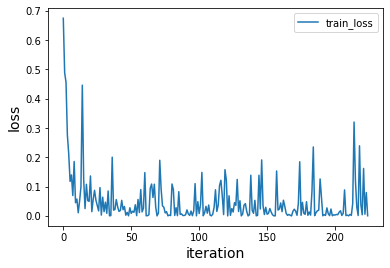

In [14]:
draw_plot(train_losses,"train_loss","iteration","loss")

In [19]:
from torchvision.models.resnet import resnet18
resnet = resnet18(pretrained=True)
model = Net(resnet)
model.load_state_dict(torch.load('resnetcatdog.pth'))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

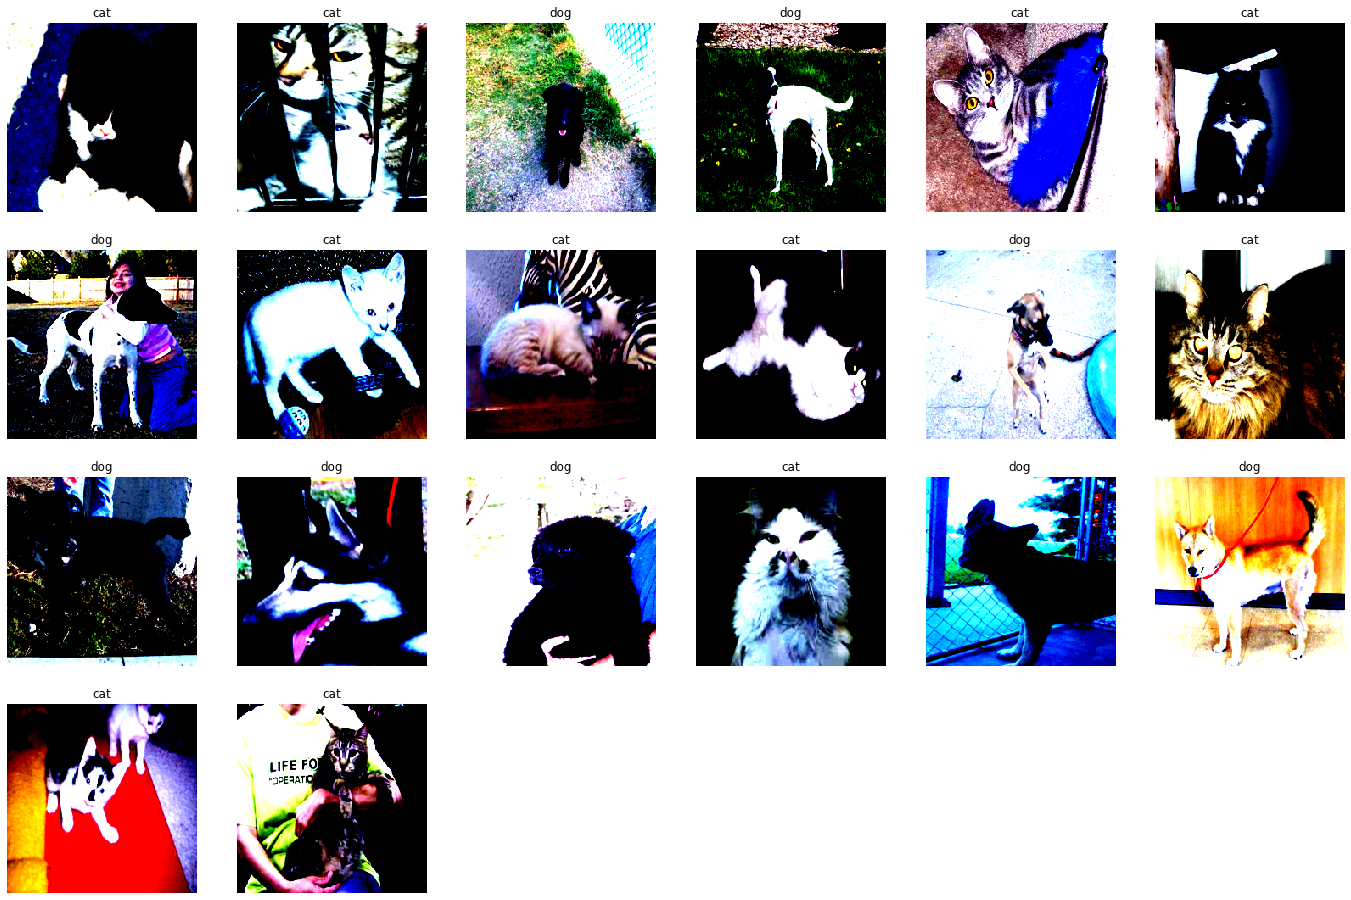

In [20]:
samples, _ = iter(test_loader).next()
samples = samples.to(DEVICE)
fig = plt.figure(figsize=(24, 16))
fig.tight_layout()
output = model(samples[:BATCH_SIZE])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]
ad = {0:'cat', 1:'dog'}
for num, sample in enumerate(samples[:BATCH_SIZE]):
    plt.subplot(4,6,num+1)
    plt.title(ad[pred[num]])
    plt.axis('off')
    sample = sample.cpu().numpy()
    plt.imshow(np.transpose(sample, (1,2,0)))